In [2]:
import os
import torch
import numpy as np

# CODE FILES HERE
from models.tdcvae.tdcvae import Encoder, Decoder, TD_Cvae, MODEL_NAME
from solver import Solver
from dataloader import DataLoader
from directories import Directories
from plots import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space,\
plot_latent_manifold, plot_prepro_params_distribution, plot_prepro_params_distribution_categories,\
plot_prepro_alpha_params_distribution, plot_prepro_radius_params_distribution, plot_faces_grid, plot_faces_samples_grid

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')
# VARIABLES HERE
load_model = False

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

optimizer = torch.optim.Adam
num_generations = 2

if dataset == "MNIST":
    batch_size = 128
    epochs = 2
    hidden_dim = 500
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 50,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [-180, 180],
        "theta_2": [-30, 30]
    }
    scales = {
        "scale_1": [0.5, 0.9],
        "scale_2": [0.2, 0.4]
    }
if dataset == "LungScans":
    batch_size = 4
    epochs = 1
    hidden_dim = 1000
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    resize = (80, 80)
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [-45, 45],
        "theta_2": [-10, 10]
    }
    scales = {
        "scale_1": [0.5, 0.9],
        "scale_2": [0.2, 0.4]
    }

In [4]:
directories = Directories(MODEL_NAME, dataset, z_dim, False)
data_loader = DataLoader(directories, batch_size, dataset, thetas=thetas, scales=scales)
model = TD_Cvae(data_loader.input_dim, hidden_dim, data_loader.input_dim, z_dim)
solver = Solver(model, data_loader, optimizer, z_dim, epochs, beta, step_config, optim_config, lr_scheduler=lr_scheduler, num_generations=num_generations, tdcvae_mode=True)
solver.main()

+++++ START RUN +++++ | no save mode


KeyboardInterrupt: 

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_SCALES_THETAS_MNIST_train_loss=151.99_z=2.pt", map_location='cpu')
#solver.model.eval()
#load_model = True

In [ ]:
# TODO: make something like a dict to insert for plot titles to avoid it has to be taken from solver obj and 
# instead we can los from dumb also.

In [ ]:
# Plotting train and test losses for all epochs
plot_losses(solver, solver.train_loss_history["train_loss_acc"], solver.test_loss_history)

In [ ]:
# Plotting the gaussian of z space and some metrics about the space
plot_gaussian_distributions(solver, len(solver.train_loss_history["train_loss_acc"]))

In [ ]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
        solver.train_loss_history["train_loss_acc"], solver.test_loss_history, \
        solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"])

In [ ]:
# visualize q(z) (latent space z)
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if (key == "theta_diff" or key == "scale_diff") and solver.data_loader.prepro_params[key]:
            z_space_labels = np.repeat(solver.data_loader.prepro_params[key], solver.data_loader.batch_size)
            if key == "theta_diff":
                ticks = np.arange(solver.data_loader.theta_range_2[0], solver.data_loader.theta_range_2[1]+1, 10).tolist()
            if key == "scale_diff":
                ticks = np.linspace(solver.data_loader.scale_range_2[0], solver.data_loader.scale_range_2[1], 6).tolist()
            num_train_samples = solver.data_loader.num_train_samples
            plot_latent_space(solver, solver.z_space[:, :2], ticks, "z", key.split("_")[0], z_space_labels[:num_train_samples])
else:
    print("Plot of latent space not possible as dimension of z is not 2")

In [ ]:
# visualize q(y)
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            y_space_labels = np.repeat(solver.data_loader.prepro_params[key], solver.data_loader.batch_size)
            if key == "theta_1":
                ticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
            if key == "scale_1":
                ticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
            num_train_samples = solver.data_loader.num_train_samples
            plot_latent_space(solver, solver.y_space[:, :2], ticks, "y", key.split("_")[0], y_space_labels[:num_train_samples])
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if not load_model:   
    if solver.z_dim == 2:
        n = 11
        if solver.data_loader.thetas:
            grid_x = np.linspace(-4, 4, n)
            grid_y = np.linspace(-4, 4, n)
        elif solver.data_loader.scales:
            grid_x = np.linspace(-3, 3, n)
            grid_y = np.linspace(-3, 3, n)
        x_t = iter(solver.data_loader.train_loader).next()[0][0][0].view(-1, solver.data_loader.input_dim)
        plot_latent_manifold(solver, "bone", grid_x, grid_y, n, x_t=x_t)
    else:
        print("Plot is not possible as dimension of z is not 2")

In [ ]:
# Bar chart over the different theta_1/scale_1 used for y_t
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            if key == "theta_1":
                xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
                plot_prepro_params_distribution(solver, xticks, key, "Angle distribution for y_t", "Count")
            if key == "scale_1":
                xticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
                plot_prepro_params_distribution(solver, xticks, key, "Scaling distribution for y_t", "Count")
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
# distribution of angles/scales with categeries/classes of dataset as bins
if solver.z_dim == 2 and solver.data_loader.with_labels:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            ytitle = "Number of elements in each bin"
            if key == "theta_1":
                xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
                plot_prepro_params_distribution_categories(solver, xticks, key, "Distribution of angles by labels", ytitle)
            if key == "scale_1":
                xticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
                plot_prepro_params_distribution_categories(solver, xticks, key, "Distribution of scales by labels", ytitle)
else:
    print("Plot of y space not possible as dimension of z is not 2 or no labeled data")

In [ ]:
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1":
            alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
            alphas = [round(x,2) for x in alphas.tolist()]
            alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
            alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
            xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist() # theta bins
            theta_alpha = list(zip(solver.data_loader.prepro_params[key], alphas)) # each theta_1 and alpha_1 paired
            plot_prepro_params_distribution(solver, xticks, key, "Archtangents distribution for y_t", "alpha distribution for theta_1 bins", data=(theta_alpha, alpha_bins))
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
if solver.z_dim == 2 and solver.data_loader.with_labels:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1":
            alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
            alphas = [round(x,2) for x in alphas.tolist()]
            alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
            alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
            theta_bins = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist() # theta bins
            theta_alpha_label = list(zip(solver.data_loader.prepro_params[key], alphas, solver.data_labels)) # each theta_1i, alpha_1i, y_i paired
            plot_prepro_params_distribution_categories(solver, theta_bins, key, "Distribution of archtangents by labels", "alpha distribution for theta_1 in bins", data=(theta_alpha_label, alpha_bins))
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
# for rotation
if solver.z_dim == 2 and solver.data_loader.thetas:
    plot_prepro_alpha_params_distribution(solver)
else:
    print("dim(z) is not 2 or rotation mode is not set")

In [ ]:
# for scaling
if solver.z_dim == 2 and solver.data_loader.scales:
    plot_prepro_radius_params_distribution(solver)
else:
    print("dim(z) is not 2 or scaling mode is not set")

(59904,)
[(-0.5, -0.42), (-0.42, -0.33), (-0.33, -0.25), (-0.25, -0.17), (-0.17, -0.08), (-0.08, 0.0), (0.0, 0.08), (0.08, 0.17), (0.17, 0.25), (0.25, 0.33), (0.33, 0.42), (0.42, 0.5)]
[433. 507. 456. 473. 595. 542. 460. 508. 474. 452. 517. 462.]
5911
[405. 529. 600. 649. 621. 497. 469. 600. 553. 595. 675. 512.]
6735
[418. 541. 542. 484. 525. 461. 478. 527. 494. 469. 521. 458.]
5944
[437. 623. 534. 491. 517. 469. 473. 568. 485. 497. 534. 468.]
6125
[437. 505. 474. 473. 526. 478. 426. 511. 451. 513. 528. 478.]
5831
[376. 464. 461. 450. 553. 445. 424. 436. 433. 455. 483. 418.]
5414
[396. 541. 544. 517. 545. 432. 461. 489. 497. 500. 531. 428.]
5909
[472. 546. 640. 568. 491. 453. 489. 579. 490. 500. 537. 463.]
6252
[393. 464. 505. 548. 553. 414. 452. 536. 464. 506. 544. 433.]
5841
[425. 496. 582. 501. 550. 438. 444. 531. 471. 508. 498. 466.]
5942


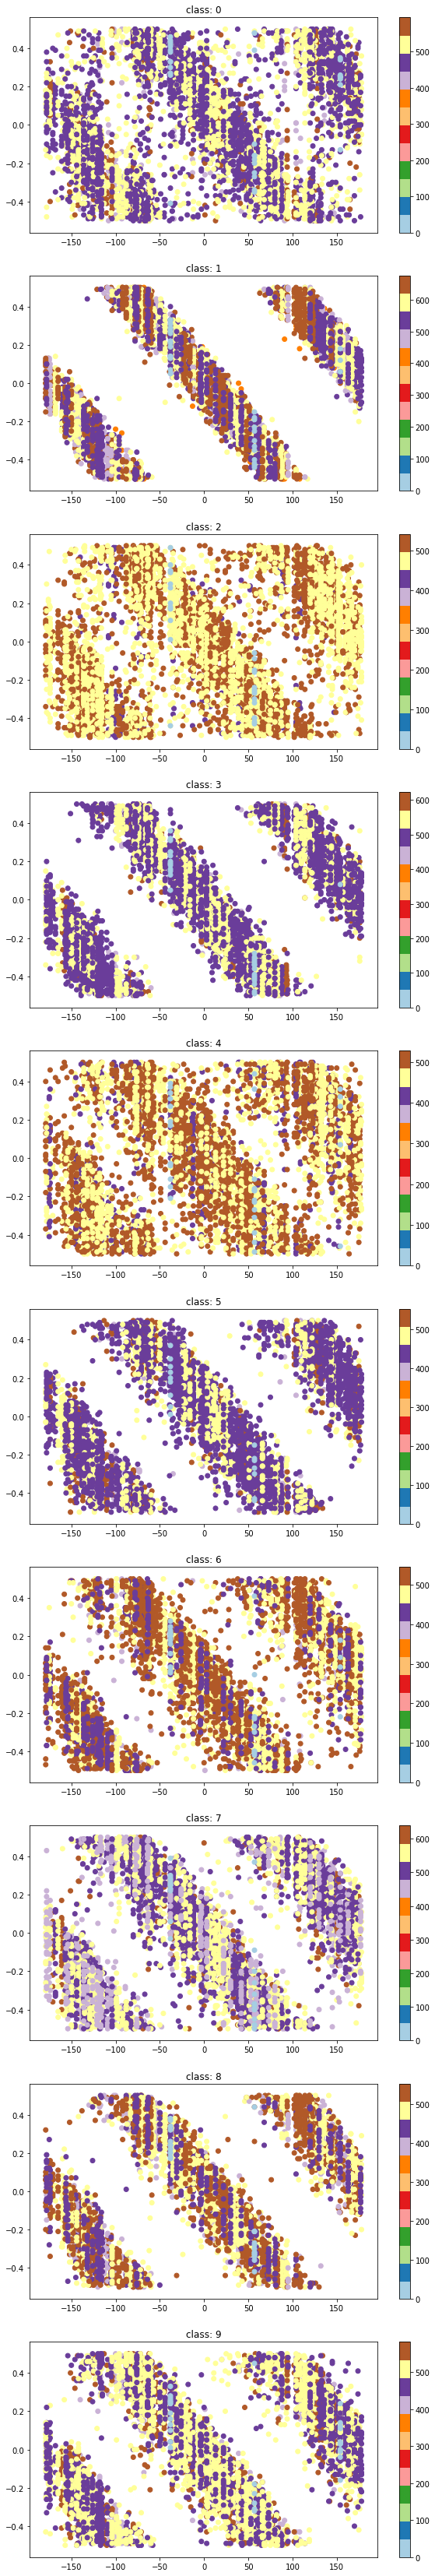

In [13]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
#solver = torch.load("../results/saved_models/model_TD_CVAE_MNIST_train_loss=88.61_z=2.pt", map_location='cpu')
solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
solver.model.eval()


alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
alphas = np.array([round(x,2) for x in alphas.tolist()])
# TODO: problem: for each batch_size, there are num_generation (thetas, alphas), we have to take that into account!
#thetas = np.repeat(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
classes = np.array(solver.data_labels)
#y_space_labels = np.repeat(solver.data_loader.prepro_params[key], solver.data_loader.batch_size)
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
#print(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
# TODO: make alphas bins and count, but then flatten the counts, and mark by counts values where each new color begins.
#print(np.sum(counts))
#print(alphas.shape, len(thetas), solver.y_space.shape, len(solver.data_loader.prepro_params["theta_1"]), classes)
# move every 10, because every 10th is the angle for index 0.
thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(thetas.shape)

paired_cmap = plt.cm.get_cmap("Paired", 12)
rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
print(alpha_bins)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    #print(counts.sum(), len(alphas_indices))
    #print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        #print(asd, offset, to_fill.shape)
        new_counts[asd:(asd+offset)] = to_fill # 0:len(to_fill), len(to_fill):len(new_to_fill)
        asd += offset
    print(len(new_counts))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
    # compute the alphas
    alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
    for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
        alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
                torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
        # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
        #if idx > 0:
        #    alphas[:, idx] -= alphas[:, 0]
    alphas = np.around(np.array(alphas), decimals=2)
    # prepare the thetas from each batch, repeat each set of theta to span over num train samples
    thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
    for gen in range(solver.num_generations):
        thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)
#thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(alphas.shape, thetas.shape)
    # create the alphas bins, corresponding to the same number as theta bins
    mini = np.min(alphas)
    maxi = np.max(alphas)
    alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
    alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins

    #paired_cmap = plt.cm.get_cmap("Paired", 12)
    #rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
    alpha_ranges = alpha_ranges[:-1]
    #norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
    fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
    classes = np.array(solver.data_labels)
    for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
        indices = np.where(classes == label)[0]
        ax.set_title("class: {}".format(label))
        counts = np.zeros(len(alpha_bins))
        alphas_indices = alphas[indices]
        for i in range(alphas.shape[1]):
            for alpha in alphas_indices[:, i]:
                for bin_idx, (x, y) in enumerate(alpha_bins):
                    if x <= alpha and alpha < y:
                        counts[bin_idx] += 1
                        break
        new_counts = np.zeros(np.prod(alphas_indices.shape))
        asd = 0
        for idx, _ in enumerate(counts):
            to_fill = counts[idx].repeat(counts[idx])
            offset = len(to_fill)
            new_counts[asd:(asd+offset)] = to_fill
            asd += offset
        print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
        scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
        fig.colorbar(scatter, ax=ax)

In [4]:
solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
solver.model.eval()

TD_Cvae(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=500, bias=True)
    (linear21): Linear(in_features=500, out_features=2, bias=True)
    (linear22): Linear(in_features=500, out_features=2, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=786, out_features=784, bias=True)
    (linear2): Linear(in_features=784, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

59110 5911 (59110,) (5911,)
67350 6735 (67350,) (6735,)
59440 5944 (59440,) (5944,)
61250 6125 (61250,) (6125,)
58310 5831 (58310,) (5831,)
54140 5414 (54140,) (5414,)
59090 5909 (59090,) (5909,)
62520 6252 (62520,) (6252,)
58410 5841 (58410,) (5841,)
59420 5942 (59420,) (5942,)


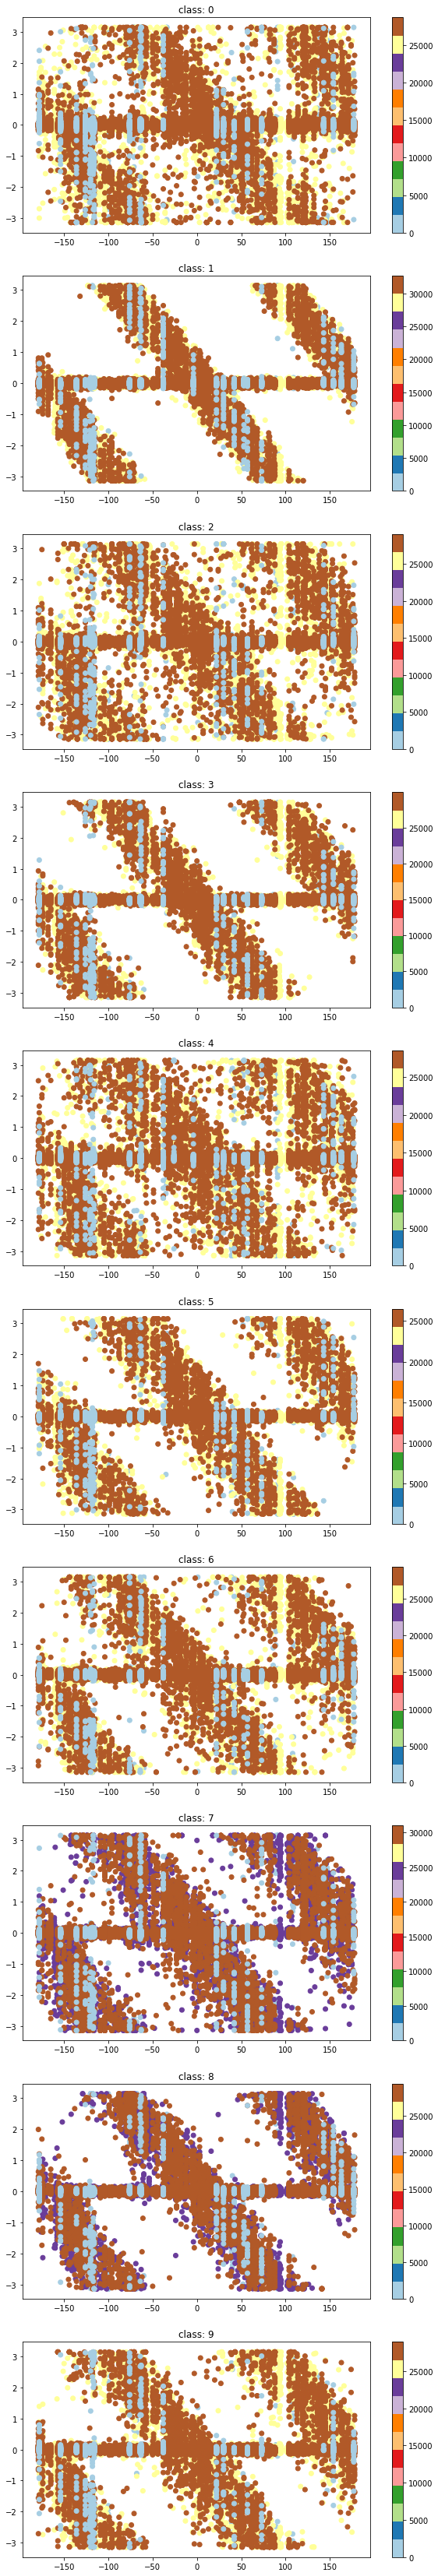

In [17]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
# compute the alphas


# TODO: we overshoot the values, e.g. for normal alphas, range is -0.5 to 0.5, but if we normalize we potentially 
# add -0.5 to -0.5, making it -1. Instead, it should be 0.5? So make some kind of modulo so clamping

alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
        
alphas = np.around(np.array(alphas), decimals=2)
mini = np.min(alphas)
maxi = np.max(alphas)
#print(alphas.shape)

for idx in range(0, alphas.shape[1]):
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    if idx > 0:
        #print(idx)
        alphas[:, idx] = np.around(alphas[:, idx] - alphas[:, 0], decimals=2)
        #print(alphas[:, idx] - alphas[:, 0])
        #print(alphas[:, idx])
        neg_indices = np.where(alphas[:, idx] < -0.5)
        pos_indices = np.where(alphas[:, idx] > 0.5)
        #print("before", alphas[neg_indices, idx])
        #print("before", alphas[pos_indices, idx])
        #print(alphas[neg_indices, :].shape, alphas[neg_indices, idx].shape, maxi, mini)
        alphas[neg_indices, idx] = mini % alphas[neg_indices, idx] #(alphas[neg_indices, idx] + maxi) % mini
        alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx] #(alphas[pos_indices, idx] + mini) % maxi
        #print("after", alphas[neg_indices, idx])
        #print("after", alphas[pos_indices, idx])

alphas = np.around(np.array(alphas), decimals=2)
mini = np.min(alphas)
maxi = np.max(alphas)
#print(mini, maxi)
# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
# For each batch we go through num_generations iterations/encodings. Thus, 
# if num_generations is 10, for prepro_params, 0-9 is for batch 0, 10-19 for batch 1 and so on. (every time on the same batch)  
#print(len(solver.data_loader.prepro_params["theta_1"]))
#print(solver.data_loader.prepro_params["theta_1"])
#exit(0)
#print(solver.data_loader.num_train_batches)
#print(solver.num_generations)
idx = 0
for batch_idx in range(solver.data_loader.num_train_batches):
    start = batch_idx*solver.data_loader.batch_size
    end = (batch_idx+1)*solver.data_loader.batch_size
    for gen in range(solver.num_generations):
        thetas[start:end, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][idx], solver.data_loader.batch_size)
        idx += 1
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    #thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
#print(alphas.shape, thetas.shape)
# create the alphas bins, corresponding to the same number as theta bins
#print(thetas)
#print(mini, maxi)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins

#paired_cmap = plt.cm.get_cmap("Paired", 12)
#rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
#norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
#print("CLASSES", classes.shape)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
radiuses = np.zeros((solver.y_space.shape[0], solver.num_generations))
centroid = np.mean(solver.y_space[:, :2], axis=0)
# compute the euclidean distance from each point y_{ij} to the center, so the radiuses
#print(solver.data_loader.train_loader.dataset.transform.transforms.prepro_params)
#print(solver.data_loader.prepro_params["scale_1"])
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)):
    radiuses[:, idx] = bla.cdist(solver.y_space[:, gen_idx:gen_idx+2], np.atleast_2d(centroid)).ravel()
    if idx > 0:
        radiuses[:, idx] -= radiuses[:, 0]
    #radiuses = np.around(np.array(radiuses), decimals=2)
    # prepare the scale from each batch, repeat each set of scales to span over num train samples
#print(solver.data_loader.prepro_params)
scales = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for idx in range(solver.num_generations):
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    scales[:, idx] = np.repeat(solver.data_loader.prepro_params["scale_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    # create the alphas bins, corresponding to the same number as theta bins
mini = np.min(radiuses)
maxi = np.max(radiuses)
radius_ranges = np.around(np.linspace(mini, maxi, 5), decimals=2)
radius_bins = list(zip(radius_ranges[:-1], radius_ranges[1:]))

fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10, 60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(radius_bins))
    radius_indices = radiuses[indices]
    for i in range(radiuses.shape[1]):
        for alpha in radius_indices[:, i]:
            for bin_idx, (x, y) in enumerate(radius_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(radius_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    scatter = ax.scatter(scales[indices, :].flatten(), radius_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
mode = ""
if thetas and scales:
    mode = "SCALES_THETAS_"
elif thetas:
    mode += "THETAS_"
elif scales:
    mode += "SCALES_"
torch.save(solver, solver.data_loader.directories.result_dir + "/model_TD_CVAE_" + mode + solver.data_loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")